In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from heisenberg_graph import (
    extract_probs,
)

In [4]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load parameters
CURRENT_TIME = "2024-12-10T09:58Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7f34db412710>, <networkx.classes.graph.Graph object at 0x7f34d83d3190>, <networkx.classes.graph.Graph object at 0x7f34d83d3950>, <networkx.classes.graph.Graph object at 0x7f34d83d8150>, <networkx.classes.graph.Graph object at 0x7f34d83d8910>, <networkx.classes.graph.Graph object at 0x7f34d83d90d0>, <networkx.classes.graph.Graph object at 0x7f34d83d9890>, <networkx.classes.graph.Graph object at 0x7f34d83da050>, <networkx.classes.graph.Graph object at 0x7f34d83da810>, <networkx.classes.graph.Graph object at 0x7f34d83dafd0>, <networkx.classes.graph.Graph object at 0x7f34d83db790>, <networkx.classes.graph.Graph object at 0x7f34d83dbf50>, <networkx.classes.graph.Graph object at 0x7f34d83e4750>, <networkx.classes.graph.Graph object at 0x7f34d83e4f10>, <networkx.classes.graph.Graph object at 0x7f34d83e56d0>, <networkx.classes.graph.Graph object at 0x7f34d83e5e90>, <networkx.classes.graph.Graph object at 0x7f34d83e6650>, <networkx.classes.grap

## Plot probability

In [6]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [7]:
with open(f"{path}/probs_phase0_sim.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [8]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [9]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

In [10]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

In [9]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [10]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [11]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [12]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

In [15]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

NameError: name 'probs_phase0_nmit_extracted' is not defined

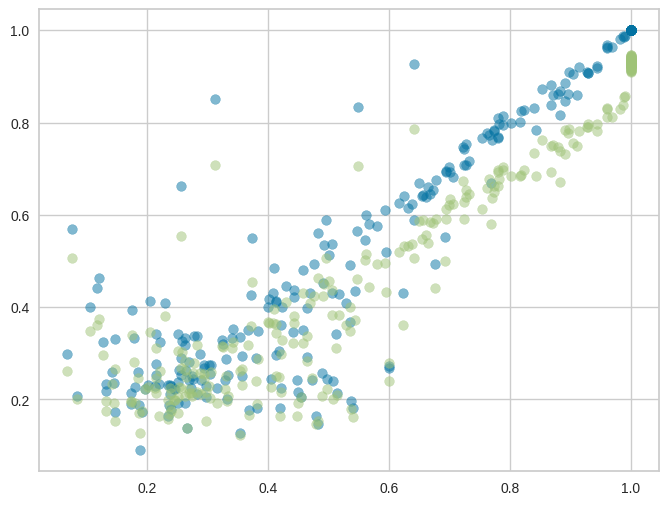

In [13]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_nmit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_mit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

NameError: name 'probs_phase1_nmit_extracted' is not defined

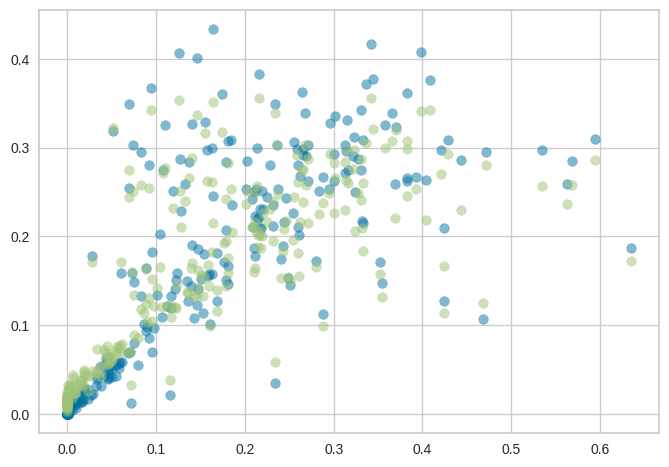

In [14]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_nmit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_mit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

NameError: name 'probs_phase2_nmit_extracted' is not defined

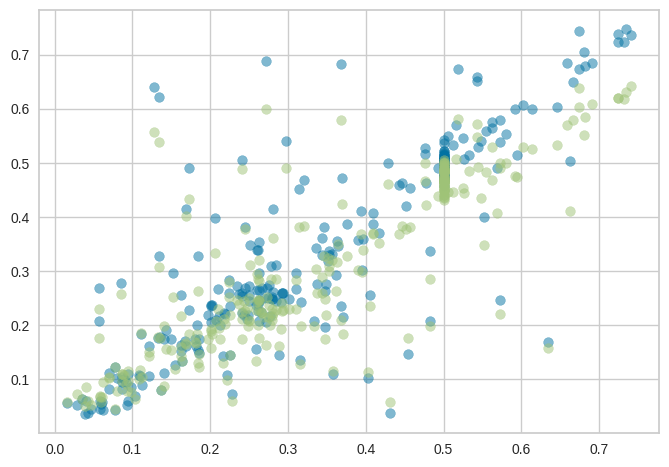

In [15]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_nmit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_mit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

NameError: name 'probs_phase3_nmit_extracted' is not defined

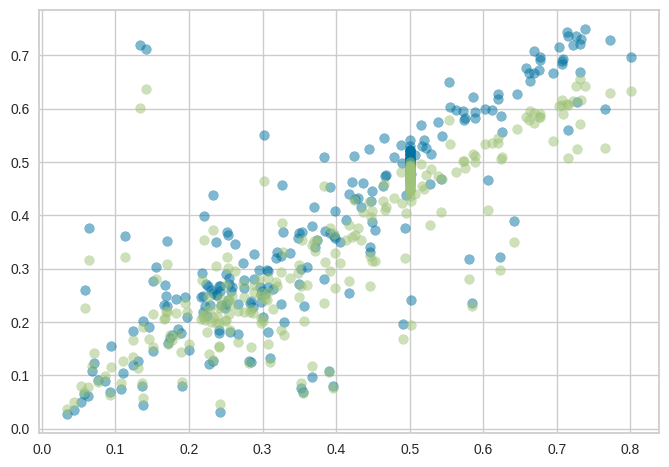

In [16]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_nmit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_mit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [17]:
data_exact_df = pd.read_json(f"{path}/data_exact_df.json")

In [18]:
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")

In [19]:
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")

In [23]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

In [20]:
# For debugging
data_mit_df = data_exact_df

In [21]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [22]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [23]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

In [28]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [24]:
print("Exact")
display(data_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.745704,0.403873,0.258853,0.429043,-0.041195,0.139711,-0.046187,-0.170563,7.391106
1,1,1,0.521817,-0.235798,-0.075684,-0.069862,0.019650,0.237055,0.238121,0.212837,7.380861
2,2,1,0.802638,-0.235200,0.344098,-0.277211,-0.103369,-0.064801,-0.332487,0.258295,1.560675
3,3,1,0.739680,0.213438,0.270651,0.214191,0.040426,0.055534,0.045735,0.061322,5.663484
4,4,1,0.710060,-0.189786,0.274111,-0.087356,0.006286,0.017487,-0.197054,0.179128,1.889904
5,5,1,0.892642,-0.129649,0.672960,-0.261482,0.509202,-0.329780,0.429986,-0.284286,2.056023
6,6,1,0.751604,-0.218926,0.352644,-0.170171,0.102798,-0.115589,-0.125449,-0.079136,1.492621
7,7,1,0.544153,-0.778113,-0.342619,-0.774325,-0.748485,-0.050095,-0.321015,0.580746,0.238580
8,8,1,0.852975,-0.075896,0.642399,-0.036575,0.579209,-0.043304,0.474411,-0.163519,1.960940
9,9,1,0.710604,0.200737,0.196163,0.228901,-0.029231,0.065537,-0.018678,-0.152263,5.800941


In [25]:
print("Simulator (noise free)")
display(data_sim_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.776178,0.411257,0.233854,0.449380,-0.073894,0.100839,-0.034862,-0.068294,7.391106
1,1,1,0.526565,-0.252850,0.063273,-0.130768,0.021167,0.031192,-0.125591,-0.064592,7.380861
2,2,1,0.811451,-0.238862,0.338276,-0.236071,-0.041975,0.030797,-0.217281,0.320222,1.560675
3,3,1,0.730612,0.213957,0.259751,0.136639,-0.026007,0.007026,-0.036856,0.173008,5.663484
4,4,1,0.700930,-0.204892,0.175612,-0.048556,-0.013156,0.017673,0.023130,-0.315711,1.889904
5,5,1,0.907169,-0.131273,0.751516,-0.201121,0.429018,-0.032748,-0.077038,0.015800,2.056023
6,6,1,0.768501,-0.190653,0.386813,-0.224354,0.026990,-0.038770,0.087417,-0.033998,1.492621
7,7,1,0.530819,-0.797722,-0.289349,-0.782210,-0.540759,-0.155714,-0.214460,0.164486,0.238580
8,8,1,0.866260,-0.061100,0.636960,-0.175741,0.089935,-0.212576,-0.083059,0.105970,1.960940
9,9,1,0.741067,0.133904,0.176097,0.105557,0.005844,-0.036659,0.216756,0.100365,5.800941


In [26]:
print("Simulator (noisy)")
display(data_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.899414,0.618991,0.322862,0.190905,0.344606,-0.057944,0.115364,-0.031027,-0.058647,7.391106
1,1,0.923828,0.422184,-0.193404,-0.007421,-0.099740,0.026035,0.054855,-0.129145,-0.080300,7.380861
2,2,0.907227,0.655078,-0.199393,0.319900,-0.202356,-0.044081,0.043316,-0.172974,0.289317,1.560675
3,3,0.929688,0.642968,0.122112,0.223618,0.136628,-0.020671,0.017685,-0.036851,0.139604,5.663484
4,4,0.915039,0.558735,-0.129151,0.139445,-0.105200,0.007809,0.024160,0.005215,-0.285179,1.889904
5,5,0.901367,0.758605,-0.113868,0.649988,-0.141236,0.307032,-0.016683,-0.021659,0.018010,2.056023
6,6,0.920898,0.632644,-0.209568,0.330168,-0.159986,0.004103,-0.051899,0.111063,-0.005851,1.492621
7,7,0.905273,0.431662,-0.634992,-0.230712,-0.634822,-0.466762,-0.127776,-0.192990,0.121013,0.238580
8,8,0.926758,0.737601,-0.036648,0.522482,-0.132352,0.058781,-0.175003,-0.113652,0.099522,1.960940
9,9,0.917969,0.539782,0.171994,0.127610,0.087660,0.000552,-0.025328,0.174001,0.082592,5.800941


In [32]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.999547,0.770891,-0.068448,0.781865,-0.095197,0.754217,-0.121768,0.732206,-0.131522,2.349069
1,1,0.996800,0.680183,-0.420971,0.605972,-0.477208,0.564426,-0.509855,0.508838,-0.572897,0.801446
2,2,0.995583,0.690874,-0.349782,0.674338,-0.368676,0.638040,-0.393899,0.642073,-0.399981,1.401454
3,3,1.000000,0.710184,-0.096861,0.707849,-0.101772,0.715745,-0.114667,0.706762,-0.120890,1.179205
4,4,1.000000,0.669674,-0.382950,0.643002,-0.389706,0.651797,-0.400999,0.610427,-0.415409,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,1.000000,0.768202,0.033795,0.745931,0.068713,0.746710,0.081659,0.728362,0.108659,5.071432
104,104,1.000000,0.695095,-0.380637,0.679436,-0.383368,0.697725,-0.359200,0.669179,-0.356386,2.536326
105,105,1.000000,0.769190,0.035838,0.748562,0.062302,0.747298,0.078683,0.748758,0.104627,4.458616
106,106,1.000000,0.742874,0.036858,0.726164,0.070483,0.739016,0.123724,0.697954,0.150650,7.820448


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.897705,0.678265,-0.059955,0.687964,-0.083857,0.663802,-0.107513,0.644010,-0.116073,2.349069
1,1,0.890137,0.598928,-0.369859,0.533439,-0.420125,0.496842,-0.448612,0.448328,-0.504283,0.801446
2,2,0.887207,0.608487,-0.307925,0.594154,-0.324820,0.561730,-0.346800,0.565451,-0.351975,1.401454
3,3,0.892334,0.626340,-0.084829,0.624542,-0.089054,0.631198,-0.100762,0.623156,-0.106110,1.179205
4,4,0.894287,0.590219,-0.337170,0.566662,-0.343257,0.574451,-0.353263,0.538485,-0.365751,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.894531,0.676820,0.030317,0.657049,0.061174,0.657683,0.072480,0.641520,0.096380,5.071432
104,104,0.900879,0.611990,-0.335295,0.598463,-0.337333,0.614312,-0.316480,0.589293,-0.314101,2.536326
105,105,0.891113,0.677287,0.031478,0.659402,0.054671,0.657756,0.069126,0.659364,0.092178,4.458616
106,106,0.888916,0.654509,0.032883,0.639477,0.062290,0.650784,0.109232,0.614724,0.132050,7.820448


## Exact

In [27]:
train_size = 0.8
session_id = 42

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 11)"
4,Transformed data shape,"(56, 10)"
5,Transformed train set shape,"(44, 10)"
6,Transformed test set shape,"(12, 10)"
7,Ignore features,2
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.4248,0.5782,0.5671,0.6141,0.1426,0.3087,0.1560
lr,Linear Regression,0.4291,0.6277,0.5761,0.5892,0.1454,0.3165,0.2670
huber,Huber Regressor,0.4353,0.7729,0.6314,0.6662,0.1432,0.2420,0.1530
et,Extra Trees Regressor,1.0582,1.7976,1.2620,0.0226,0.3169,0.5829,0.0180
ada,AdaBoost Regressor,1.0926,2.2449,1.3059,-0.0920,0.3173,0.4957,0.0110
rf,Random Forest Regressor,1.2130,2.4770,1.4405,-0.3693,0.3621,0.6309,0.0210
gbr,Gradient Boosting Regressor,1.2414,2.6111,1.4428,-0.4863,0.3698,0.6022,0.0090
knn,K Neighbors Regressor,1.2928,2.6824,1.5503,-1.0874,0.3977,0.8613,0.0080
ridge,Ridge Regression,1.2125,2.7053,1.4718,-0.8580,0.3771,0.7520,0.1580
omp,Orthogonal Matching Pursuit,1.3134,3.2364,1.5222,-0.6282,0.3517,0.5644,0.1600


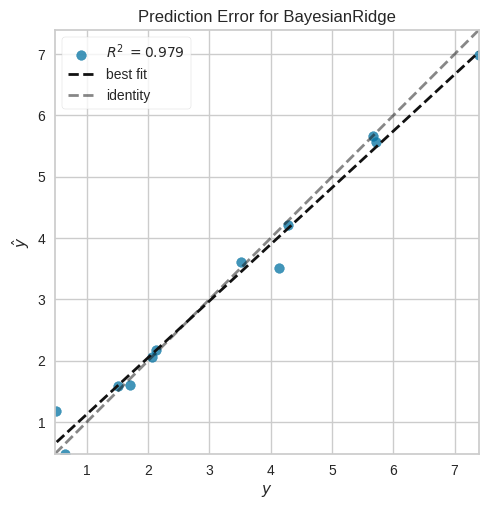

In [28]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    # Note: エラーするかも
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
best_exact = s_exact.compare_models(turbo=True, sort="MSE")

s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 11)"
4,Transformed data shape,"(56, 10)"
5,Transformed train set shape,"(44, 10)"
6,Transformed test set shape,"(12, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.0037,2.0924,1.2298,0.1158,0.3004,0.4423,0.0060
br,Bayesian Ridge,1.1172,2.1863,1.3301,-0.3389,0.3312,0.5749,0.0050
et,Extra Trees Regressor,1.2091,2.4167,1.4297,-0.2498,0.3264,0.5422,0.0170
lr,Linear Regression,1.1747,2.4453,1.4002,-0.3590,0.3366,0.5481,0.0050
ridge,Ridge Regression,1.3250,2.7151,1.5295,-0.6100,0.3810,0.7953,0.0050
ada,AdaBoost Regressor,1.1700,2.7373,1.4763,-0.3306,0.3442,0.5674,0.0100
knn,K Neighbors Regressor,1.3346,3.0256,1.6384,-0.6368,0.3866,0.6772,0.0080
rf,Random Forest Regressor,1.3489,3.1330,1.6752,-0.9286,0.3896,0.6825,0.0220
omp,Orthogonal Matching Pursuit,1.3035,3.1957,1.5129,-0.5890,0.3457,0.5464,0.0050
gbr,Gradient Boosting Regressor,1.4064,3.4420,1.6652,-0.7025,0.3987,0.6778,0.0090


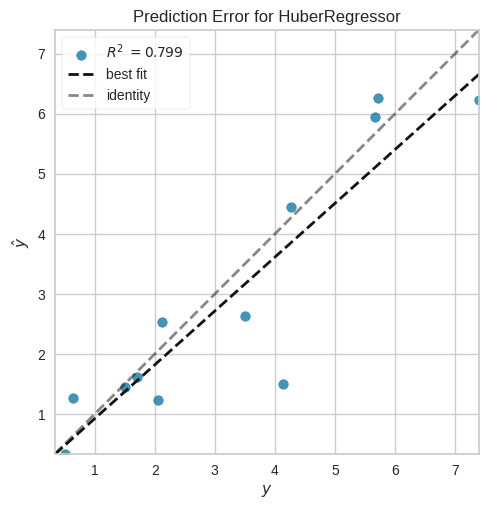

In [29]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim = s_sim.compare_models(turbo=True, sort="MSE")

s_sim.plot_model(best_sim, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:17:46
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9125,1.4845,1.2184,0.5997,0.2350,0.2675
1,1.9216,4.0881,2.0219,-0.3800,0.4541,0.7609
2,1.2118,1.6638,1.2899,0.6495,0.4244,0.9764
3,1.6124,2.7264,1.6512,-5.3755,0.4783,1.0044
4,2.1239,4.8111,2.1934,0.0241,0.3988,0.4850
5,1.6025,5.6771,2.3827,0.0602,0.4398,0.4034
6,0.7920,1.2932,1.1372,0.8248,0.1498,0.1352
7,0.8053,1.0139,1.0069,-0.2670,0.2286,0.2706
8,0.1604,0.0537,0.2318,0.8171,0.1551,0.5100


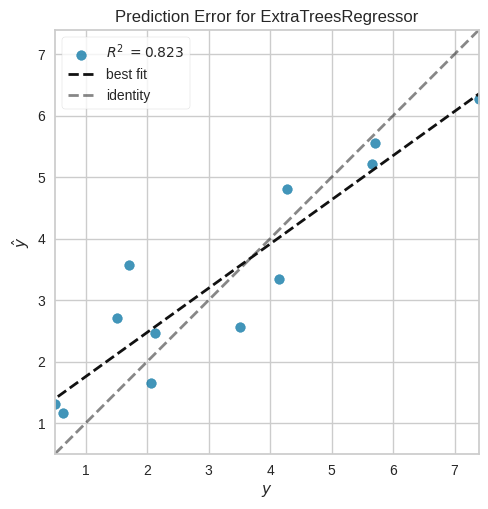

In [30]:
manual_model_sim = s_sim.create_model("et")
s_sim.plot_model(manual_model_sim, plot="error")

## Trotter (Simulation, Noisy)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 11)"
4,Transformed data shape,"(56, 10)"
5,Transformed train set shape,"(44, 10)"
6,Transformed test set shape,"(12, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.9942,1.7779,1.1718,0.2962,0.2764,0.4492,0.0070
lr,Linear Regression,1.0256,1.9154,1.2315,0.0166,0.2945,0.5149,0.0050
br,Bayesian Ridge,1.0723,1.9803,1.2801,-0.2661,0.3218,0.5630,0.0050
et,Extra Trees Regressor,1.1320,2.1265,1.3543,-0.0642,0.3173,0.5436,0.0170
knn,K Neighbors Regressor,1.2594,2.7367,1.5621,-0.5174,0.3666,0.6368,0.0080
ridge,Ridge Regression,1.3483,2.7759,1.5454,-0.6738,0.3883,0.8295,0.0050
rf,Random Forest Regressor,1.2012,2.8883,1.5084,-0.3616,0.3465,0.5373,0.0210
ada,AdaBoost Regressor,1.2221,3.0795,1.5787,-0.6279,0.3645,0.6020,0.0110
omp,Orthogonal Matching Pursuit,1.2934,3.1216,1.5014,-0.5949,0.3451,0.5534,0.0050
gbr,Gradient Boosting Regressor,1.2432,3.2254,1.5722,-0.5054,0.3424,0.4716,0.0100


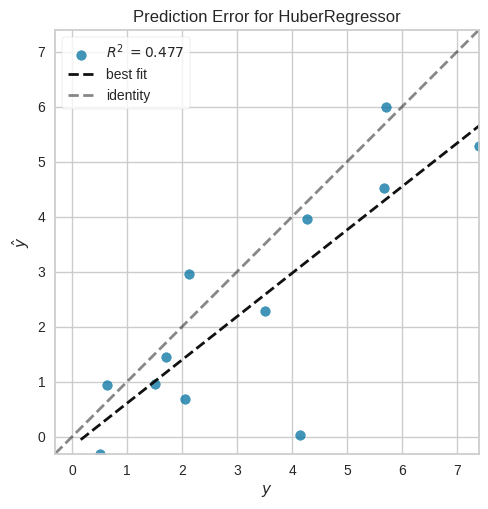

In [31]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort="MSE")
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.2130,8.1039,2.6894,0.1755,0.5151,1.2522,0.0120
lr,Linear Regression,2.2591,8.1073,2.7058,0.1322,0.5231,1.2336,0.0120
lar,Least Angle Regression,2.2591,8.1073,2.7058,0.1322,0.5231,1.2336,0.0090
huber,Huber Regressor,1.8915,8.8375,2.6906,0.3524,0.4541,0.8515,0.0100
et,Extra Trees Regressor,2.2016,9.4599,2.9450,-0.3990,0.5787,1.4723,0.0420
knn,K Neighbors Regressor,2.3009,10.3033,3.0994,-0.2383,0.5838,1.3221,0.0150
gbr,Gradient Boosting Regressor,2.3288,10.7308,3.1807,-0.1153,0.6011,1.3667,0.0170
rf,Random Forest Regressor,2.3714,10.8689,3.1807,-0.2577,0.6180,1.6380,0.0530
ada,AdaBoost Regressor,2.4295,10.9214,3.1805,-0.1846,0.6463,1.9078,0.0170
lightgbm,Light Gradient Boosting Machine,2.5861,11.4646,3.3205,-0.3879,0.6130,1.5626,0.1590


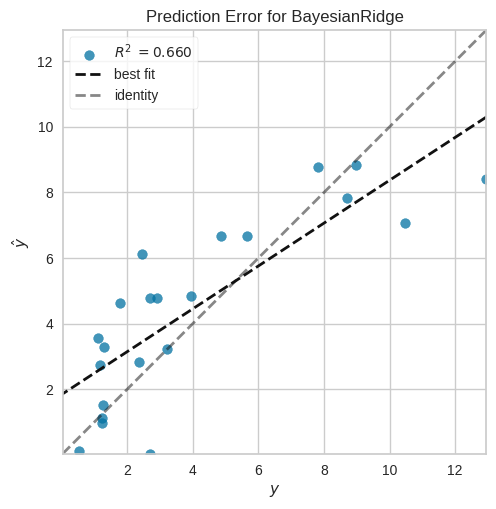

In [51]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_nmit = s_nmit.compare_models(turbo=True, sort="MSE")
s_nmit.plot_model(best_nmit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:43:59
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5568,5.9679,2.4429,0.3843,0.5873,1.4466
1,1.6207,5.6072,2.3680,0.4180,0.3765,0.7601
2,1.2584,2.3923,1.5467,0.7474,0.4286,0.6748
3,1.7729,6.2442,2.4988,0.6969,0.5317,3.0351
4,1.6753,4.9806,2.2317,0.5506,0.5427,1.4992
5,2.3734,12.1536,3.4862,0.1973,0.5665,0.9186
6,3.6716,21.6515,4.6531,-0.4336,0.6500,0.4843
7,2.7034,10.7826,3.2837,0.6113,0.7377,2.5305
8,2.1637,8.1732,2.8589,-7.3069,0.6805,2.1871


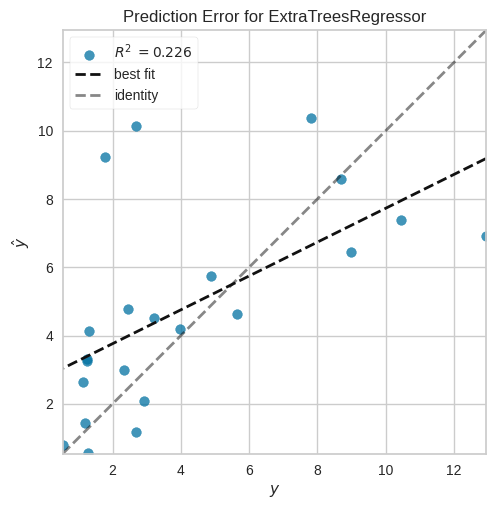

In [52]:
manual_model_nmit = s_nmit.create_model("et")
s_nmit.plot_model(manual_model_nmit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5534,2.7570,1.6604,0.7156,0.4932,1.2447
1,2.6796,8.1203,2.8496,0.1572,0.5561,1.7440
2,0.9271,1.2114,1.1006,0.8721,0.2409,0.6668
3,1.7185,5.8669,2.4222,0.7152,0.3971,0.8726
4,2.1886,7.1164,2.6677,0.3578,0.5834,1.6650
5,2.6510,10.9891,3.3150,0.2742,0.5758,1.7311
6,3.2508,18.5422,4.3061,-0.2277,0.5397,0.4950
7,2.4297,10.4858,3.2382,0.6220,0.5303,1.3643
8,1.5817,2.9799,1.7262,-2.0286,0.5376,1.4159


Fitting 10 folds for each of 10 candidates, totalling 100 fits


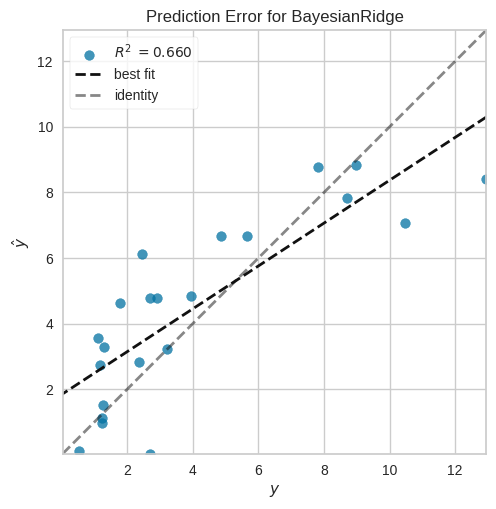

In [53]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [54]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_mit = s_mit.compare_models(turbo=True, sort="MSE")

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.2185,8.1648,2.6971,0.1724,0.5167,1.2535,0.0090
lar,Least Angle Regression,2.2476,8.4486,2.7421,0.1160,0.5155,1.2469,0.0090
lr,Linear Regression,2.2476,8.4487,2.7421,0.1160,0.5155,1.2469,0.0100
huber,Huber Regressor,1.8727,8.8377,2.6843,0.3497,0.4624,0.8595,0.0110
et,Extra Trees Regressor,2.1943,9.2828,2.9281,-0.2981,0.5789,1.5598,0.0420
knn,K Neighbors Regressor,2.3369,10.4214,3.1178,-0.2401,0.5918,1.3542,0.0140
rf,Random Forest Regressor,2.3854,10.4588,3.1301,-0.2720,0.6205,1.7739,0.0550
gbr,Gradient Boosting Regressor,2.3542,10.6126,3.1536,-0.2701,0.6220,1.4582,0.0160
ada,AdaBoost Regressor,2.5074,10.9043,3.1929,-0.1973,0.6697,2.1004,0.0170
lightgbm,Light Gradient Boosting Machine,2.6009,11.1271,3.2623,-0.3322,0.6301,1.8357,0.1780


In [55]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value,prediction_label
77,0.896484,0.676032,-0.052285,0.650849,-0.069817,0.653035,-0.046061,0.638061,-0.084846,1.303712,3.278563
10,0.895264,0.660208,-0.035615,0.683370,-0.004292,0.660893,-0.013222,0.657025,0.004841,2.461009,6.071016
4,0.894287,0.590219,-0.337170,0.566662,-0.343257,0.574451,-0.353263,0.538485,-0.365751,1.121292,3.525186
83,0.896729,0.633309,-0.059070,0.631361,-0.111647,0.606533,-0.169223,0.571916,-0.210032,0.538452,0.065565
62,0.885498,0.616736,-0.264343,0.583799,-0.271645,0.590174,-0.303548,0.576060,-0.284877,3.209185,3.266774
67,0.882080,0.579062,-0.264702,0.589364,-0.241069,0.580063,-0.235514,0.580726,-0.177493,10.461210,7.133326
30,0.894043,0.634427,-0.113691,0.599266,-0.168913,0.568512,-0.228954,0.550985,-0.273994,2.697981,-0.002379
45,0.886475,0.546281,-0.387194,0.505117,-0.437042,0.448180,-0.470058,0.368534,-0.507647,2.912899,4.835387
95,0.892822,0.535460,-0.363669,0.546999,-0.361888,0.528871,-0.397138,0.533517,-0.400228,1.185558,2.712701
11,0.895264,0.619842,-0.259771,0.616844,-0.225394,0.620482,-0.183654,0.632262,-0.132499,8.700416,7.806945


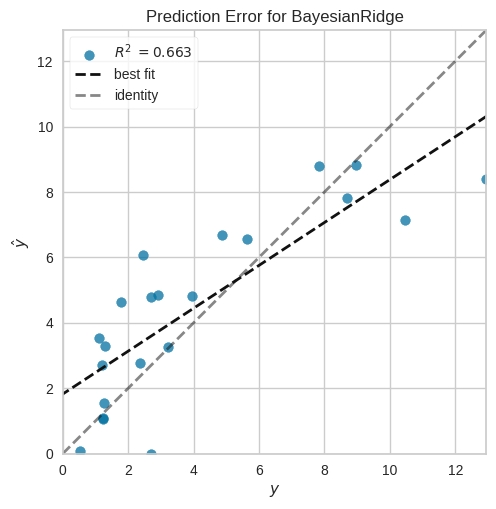

In [56]:
s_mit.plot_model(best_mit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:12
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5199,2.6586,1.6305,0.7257,0.4898,1.2413
1,2.7015,8.2434,2.8711,0.1444,0.5574,1.7244
2,0.8984,1.1987,1.0948,0.8734,0.2356,0.6226
3,1.7462,5.9601,2.4413,0.7107,0.4029,0.9629
4,2.2135,7.2097,2.6851,0.3494,0.5903,1.7021
5,2.6573,11.0620,3.3260,0.2694,0.5772,1.7378
6,3.2200,18.4056,4.2902,-0.2187,0.5351,0.4845
7,2.4465,10.5515,3.2483,0.6196,0.5301,1.3838
8,1.5798,2.9866,1.7282,-2.0354,0.5366,1.4093


Fitting 10 folds for each of 10 candidates, totalling 100 fits


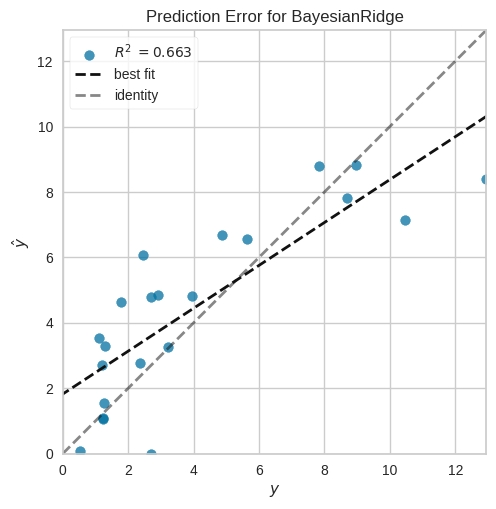

In [57]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:13
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3995,4.4560,2.1109,0.5403,0.5287,1.2047
1,1.8768,6.5737,2.5639,0.3177,0.4104,0.8072
2,1.3079,2.4970,1.5802,0.7364,0.4465,0.7144
3,1.7470,6.4886,2.5473,0.6850,0.5625,3.8716
4,1.8232,6.3710,2.5241,0.4251,0.5501,1.4660
5,2.3126,12.3128,3.5090,0.1867,0.5719,1.0406
6,3.4283,19.3557,4.3995,-0.2816,0.5948,0.4310
7,2.7281,10.1989,3.1936,0.6324,0.7600,2.7517
8,2.1051,7.2129,2.6857,-6.3309,0.6642,2.1636


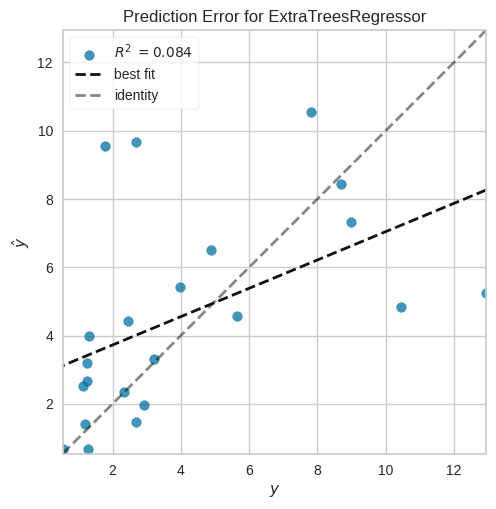

In [58]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")